In [5]:
import torch
import random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import Subset
from more_itertools import chunked


num_nodes = 10
hetero_k = 4
all_classes = list(range(10))
node_label = [[] for _ in range(num_nodes)]
# each label is allocated at least one node and each node has max k classes
for label in all_classes:
    append_flag = True
    while append_flag:
        selected_node = random.randint(0,num_nodes-1)
        if len(node_label[selected_node])< hetero_k:
            node_label[selected_node].append(label)
            append_flag = False

for node in range(num_nodes):
    remaining_classes = [label for label in all_classes if label not in node_label[node]]
    current_classes = len(node_label[node])

    num_additional_classes = max(0,min(hetero_k-current_classes,len(remaining_classes)))
    additional_classes = random.sample(remaining_classes,k = num_additional_classes)
    node_label[node]+=additional_classes


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10('./data',
                    train=True,
                    download=True,
                    transform=transform_train)

test_dataset = datasets.CIFAR10('./data',
                    train=False,
                    transform=transform_test)

n_train = len(train_dataset)
n_node = len(node_label)

# train_dataset = torch.utils.data.random_split(train_dataset,n_train)

label_node = []

for label in range(10):
    label_node.append([])
    for node in range(n_node):
        if label in node_label[node]:
            label_node[-1].append(node)

node_indices = [[] for i in range(n_node)]

for label in range(10):
    indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i]==label]
    random.shuffle(indices)
    chunked_indices = list(chunked(indices, int(len(indices)/len(label_node[label]))))

    for i in range(len(label_node[label])):
        node_indices[label_node[label][i]] += chunked_indices[i]

for i in range(n_node):
    random.shuffle(node_indices[i])
n_data = min([len(node_indices[i]) for i in range(n_node)])
    
train_subset_list = [Subset(train_dataset, node_indices[i][:n_data]) for i in range(n_node)]
train_iters = [torch.utils.data.DataLoader(train_subset_list[i], batch_size=256, shuffle=True) for i in range(num_nodes)]

Files already downloaded and verified


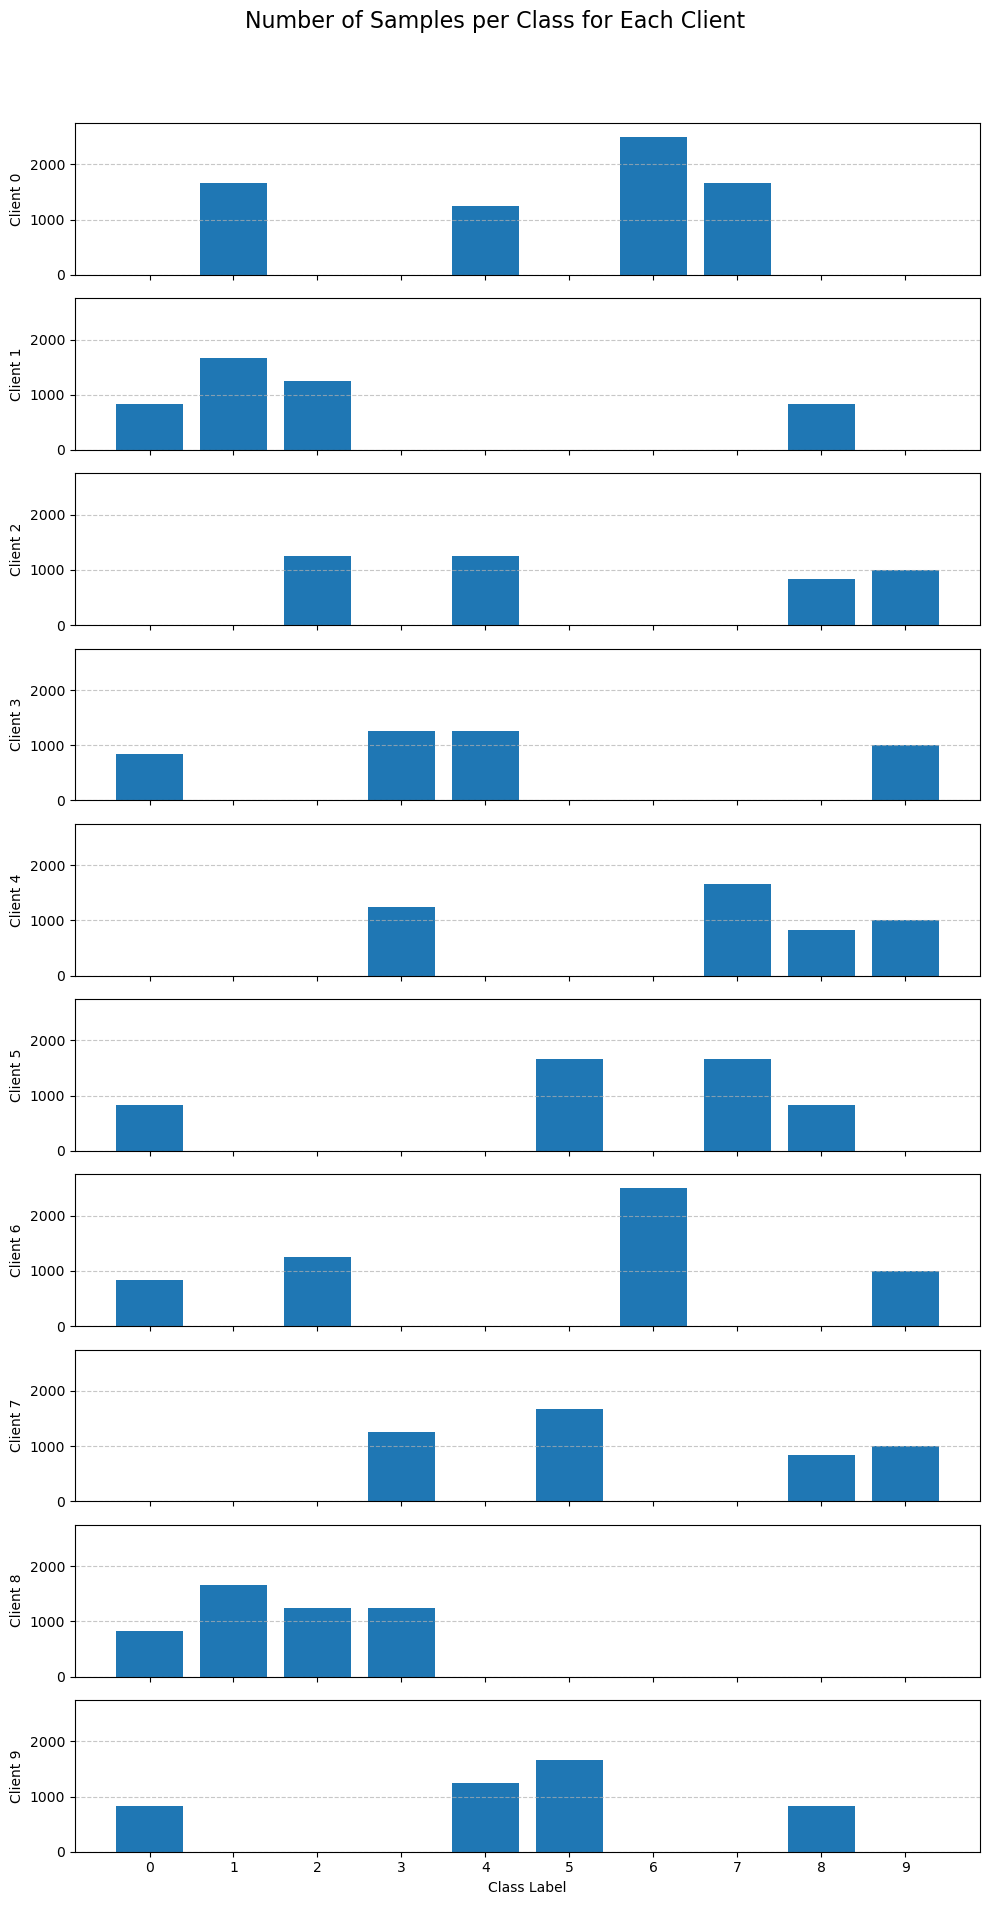

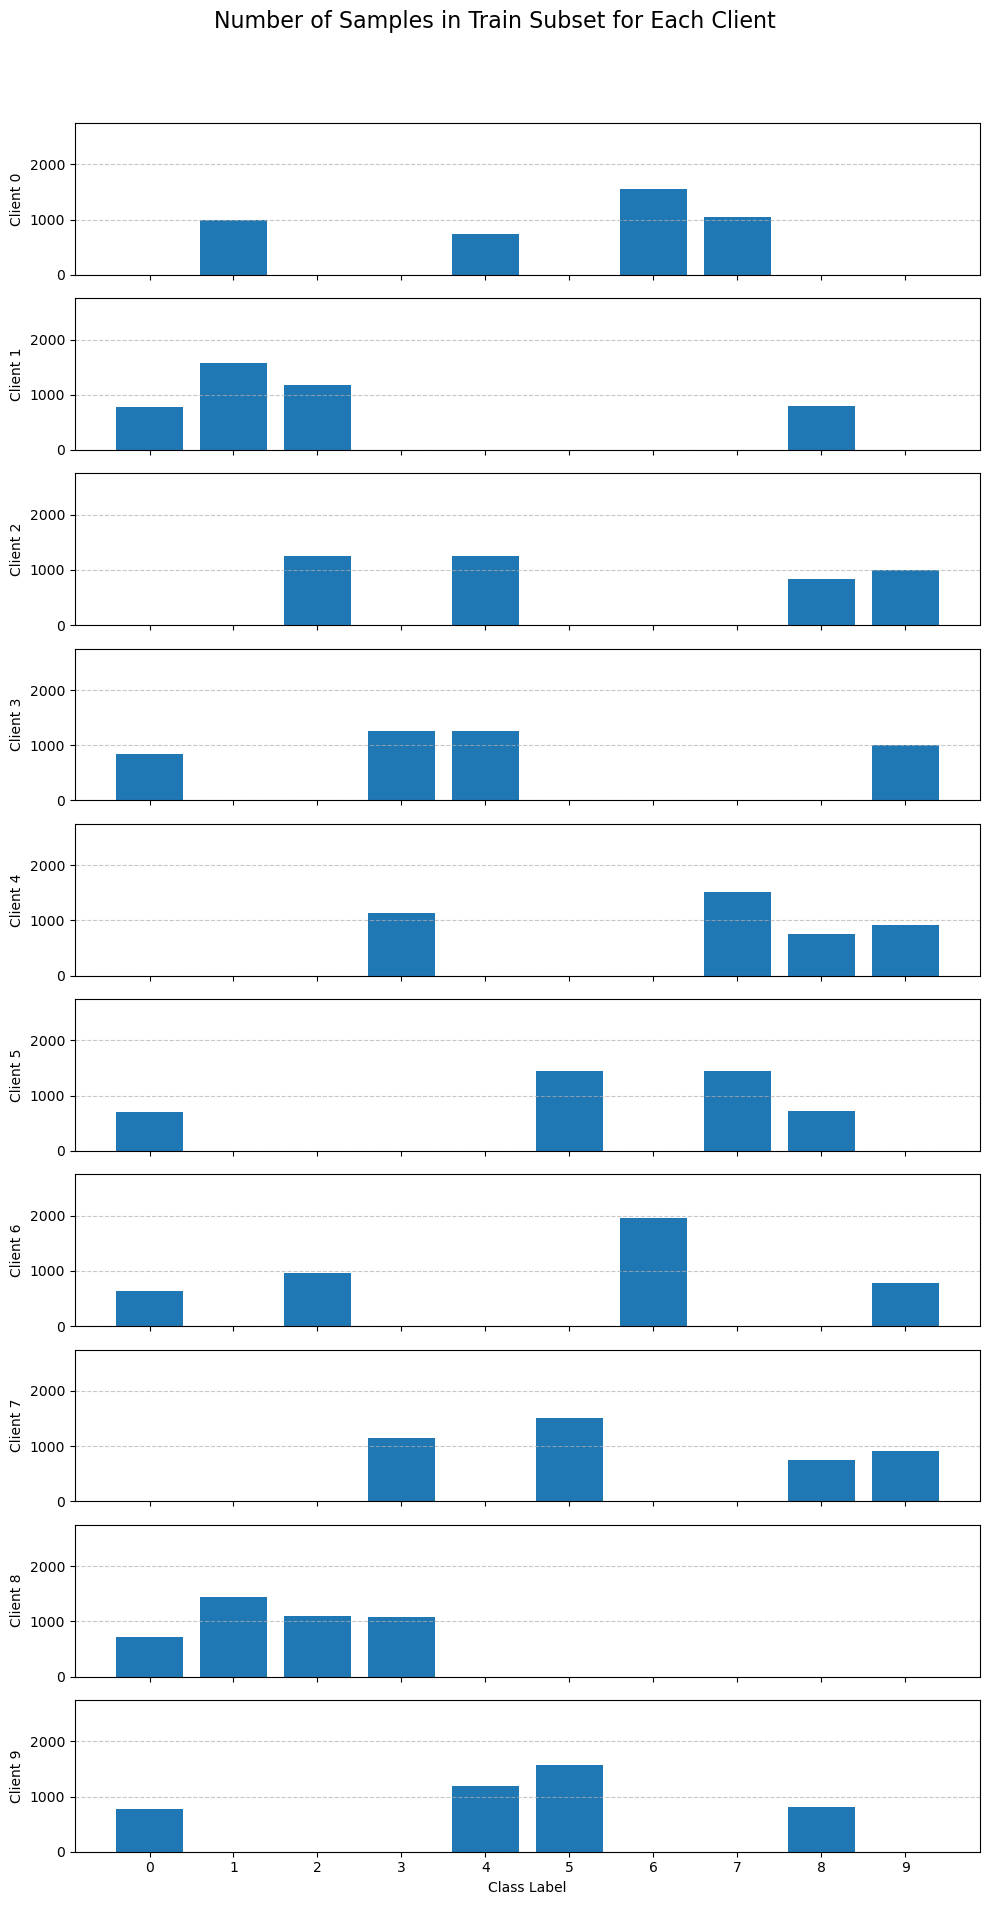

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# 各クライアントごとのクラスのデータ数をカウント
data_counts = []
for i in range(n_node):
    class_counts = [0] * 10  # クラス数は10と仮定
    for idx in node_indices[i]:
        label = train_dataset.targets[idx]
        class_counts[label] += 1
    data_counts.append(class_counts)

# クラスのデータ数の可視化
fig, axs = plt.subplots(n_node, 1, figsize=(10, 2 * n_node), sharex=True)
fig.suptitle('Number of Samples per Class for Each Client', fontsize=16)

x = np.arange(10)  # クラスラベル (0-9)

for i in range(n_node):
    axs[i].bar(x, data_counts[i])
    axs[i].set_ylabel(f'Client {i}')
    axs[i].set_ylim(0, max(max(data_counts[i]) for i in range(n_node)) * 1.1)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel('Class Label')
plt.xticks(x)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# train_subset_list の可視化
fig, axs = plt.subplots(n_node, 1, figsize=(10, 2 * n_node), sharex=True)
fig.suptitle('Number of Samples in Train Subset for Each Client', fontsize=16)

for i in range(n_node):
    loader = DataLoader(train_subset_list[i], batch_size=len(train_subset_list[i]), shuffle=False)
    batch = next(iter(loader))
    labels = batch[1].numpy()
    class_counts = [np.sum(labels == label) for label in range(10)]
    axs[i].bar(x, class_counts)
    axs[i].set_ylabel(f'Client {i}')
    axs[i].set_ylim(0, max(max(class_counts) for class_counts in data_counts) * 1.1)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel('Class Label')
plt.xticks(x)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Iteration 0:
 Node 0: [ 1.5406442  -0.49378958]
 Node 1: [1.8084855  0.23904525]
 Node 2: [ 2.5663524 -0.6477422]
 Node 3: [2.2270553  0.23935643]


/tmp/ipykernel_22346/2645801717.py:27: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  gradients.append(params[i].grad.clone())  # 勾配を保存


AttributeError: 'NoneType' object has no attribute 'clone'

Iteration 0: Params [array([1.149843  , 0.11549113], dtype=float32), array([-0.5364433 , -0.19119927], dtype=float32), array([ 1.1527737 , -0.44876692], dtype=float32), array([ 1.2253975, -2.1077695], dtype=float32)] 
Iteration 10: Params [array([4.0527577, 0.7028935], dtype=float32), array([2.3664718, 0.3962031], dtype=float32), array([4.0556884 , 0.13863547], dtype=float32), array([ 4.128312 , -1.5203671], dtype=float32)] 
Iteration 20: Params [array([4.364456 , 0.7659654], dtype=float32), array([2.6781697 , 0.45927492], dtype=float32), array([4.367387  , 0.20170729], dtype=float32), array([ 4.4400105, -1.4572953], dtype=float32)] 
Iteration 30: Params [array([4.3979244 , 0.77273774], dtype=float32), array([2.7116382 , 0.46604723], dtype=float32), array([4.400855  , 0.20847955], dtype=float32), array([ 4.473479, -1.450523], dtype=float32)] 
Iteration 40: Params [array([4.4015183, 0.773465 ], dtype=float32), array([2.7152314 , 0.46677434], dtype=float32), array([4.404449  , 0.20920669

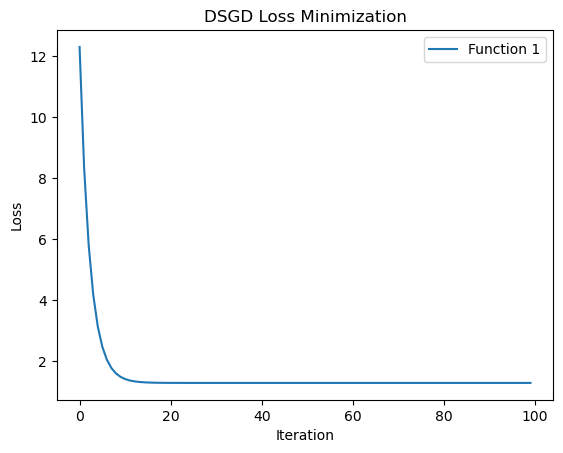

Iteration 0: Params [array([1.9957997, 1.2836808], dtype=float32), array([0.33612943, 1.747783  ], dtype=float32), array([-1.7082108,  1.4153296], dtype=float32), array([-1.4035903,  1.2010434], dtype=float32)] 
Iteration 10: Params [array([2.169833, 4.486459], dtype=float32), array([0.5101629, 4.950561 ], dtype=float32), array([-1.5341773,  4.6181073], dtype=float32), array([-1.2295568,  4.403821 ], dtype=float32)] 
Iteration 20: Params [array([2.1885197, 4.830354 ], dtype=float32), array([0.5288496, 5.2944565], dtype=float32), array([-1.5154905,  4.9620028], dtype=float32), array([-1.21087  ,  4.7477164], dtype=float32)] 
Iteration 30: Params [array([2.190526, 4.86728 ], dtype=float32), array([0.5308559, 5.3313823], dtype=float32), array([-1.5134839,  4.9989285], dtype=float32), array([-1.2088634,  4.784642 ], dtype=float32)] 
Iteration 40: Params [array([2.1907413, 4.871245 ], dtype=float32), array([0.53107136, 5.335347  ], dtype=float32), array([-1.5132685,  5.0028934], dtype=float

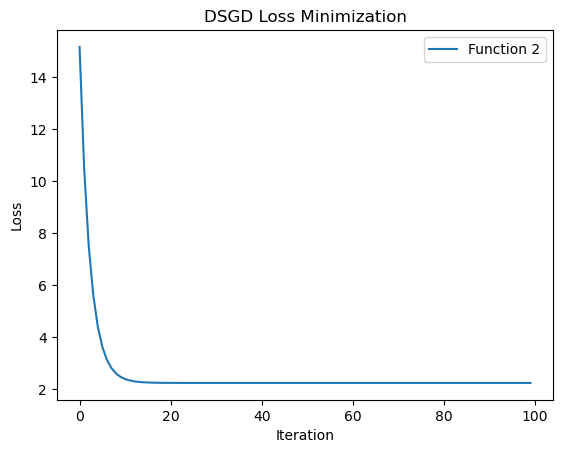

In [4]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 二変数の凸関数の定義
def function_1(x, y):
    return (x - 4) ** 2 + y ** 2

def function_2(x, y):
    return x ** 2 + (y - 5) ** 2

# 勾配計算のために関数をPyTorchのテンソルを用いて定義
def function_1_tensor(params):
    x, y = params[0], params[1]
    return (x - 4) ** 2 + y ** 2

def function_2_tensor(params):
    x, y = params[0], params[1]
    return x ** 2 + (y - 5) ** 2

# シミュレーションパラメータ
num_workers = 4  # ワーカー数
learning_rate = 0.1
num_iterations = 100

# 初期化
params = [torch.randn(2, requires_grad=True) for _ in range(num_workers)]
optimizers = [optim.SGD([param], lr=learning_rate) for param in params]

# DSGDシミュレーション
def dsgd_minimize(function_tensor, params, optimizers, num_iterations, num_workers, function_name):
    loss_values = []
    for iteration in range(num_iterations):
        # 各ワーカーが独立に勾配を計算
        local_grads = []
        for i in range(num_workers):
            optimizers[i].zero_grad()
            loss = function_tensor(params[i])
            loss.backward()
            local_grads.append(params[i].grad.clone())

        # グローバル平均勾配を計算
        global_grad = sum(local_grads) / num_workers

        # 各ワーカーのパラメータを更新
        for i in range(num_workers):
            params[i].grad = global_grad
            optimizers[i].step()

        # 損失値を記録
        avg_loss = sum(function_tensor(param).item() for param in params) / num_workers
        loss_values.append(avg_loss)

        # 現在の状態を出力
        if iteration % 10 == 0 or iteration == num_iterations - 1:
            print(f"Iteration {iteration}: Params {[param.detach().numpy() for param in params]} ")
    
    # 損失値の可視化
    plt.plot(range(num_iterations), loss_values, label=function_name)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('DSGD Loss Minimization')
    plt.legend()
    plt.show()

# Function 1 の最小化
dsgd_minimize(function_1_tensor, params, optimizers, num_iterations, num_workers, 'Function 1')

# Function 2 の最小化
params = [torch.randn(2, requires_grad=True) for _ in range(num_workers)]
optimizers = [optim.SGD([param], lr=learning_rate) for param in params]
dsgd_minimize(function_2_tensor, params, optimizers, num_iterations, num_workers, 'Function 2')


Iteration 0: Params [array([2.7306488, 1.7694358], dtype=float32), array([ 1.3353295, -1.3702947], dtype=float32), array([-0.19292179, -0.02882685], dtype=float32), array([0.43060172, 1.5167216 ], dtype=float32)] 
Iteration 10: Params [array([4.725399 , 1.4476116], dtype=float32), array([ 3.3300796, -1.6921189], dtype=float32), array([ 1.801828  , -0.35065106], dtype=float32), array([2.4253519, 1.1948974], dtype=float32)] 
Iteration 20: Params [array([6.795576 , 1.1136184], dtype=float32), array([ 5.400257 , -2.0261118], dtype=float32), array([ 3.872006 , -0.6846443], dtype=float32), array([4.495529 , 0.8609043], dtype=float32)] 
Iteration 30: Params [array([5.829895, 1.269417], dtype=float32), array([ 4.434576 , -1.8703132], dtype=float32), array([ 2.906325  , -0.52884555], dtype=float32), array([3.529848 , 1.0167029], dtype=float32)] 
Iteration 40: Params [array([5.2340884, 1.3655417], dtype=float32), array([ 3.8387694, -1.7741885], dtype=float32), array([ 2.310519  , -0.43272096], d

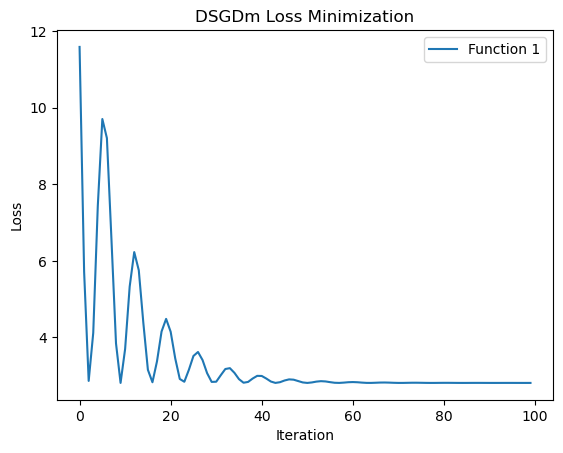

Iteration 0: Params [array([-0.20638865, -0.41137198], dtype=float32), array([1.0416958, 1.7821234], dtype=float32), array([0.62133545, 1.8778336 ], dtype=float32), array([ 0.14097172, -0.00475291], dtype=float32)] 
Iteration 10: Params [array([-0.47885343,  2.446305  ], dtype=float32), array([0.7692311, 4.639801 ], dtype=float32), array([0.34887066, 4.735511  ], dtype=float32), array([-0.13149308,  2.852924  ], dtype=float32)] 
Iteration 20: Params [array([-0.76162094,  5.4120393 ], dtype=float32), array([0.48646358, 7.605535  ], dtype=float32), array([0.06610314, 7.701245  ], dtype=float32), array([-0.4142606,  5.8186584], dtype=float32)] 
Iteration 30: Params [array([-0.6297176,  4.0286055], dtype=float32), array([0.6183669, 6.2221007], dtype=float32), array([0.19800636, 6.3178105 ], dtype=float32), array([-0.28235734,  4.4352245 ], dtype=float32)] 
Iteration 40: Params [array([-0.54833585,  3.1750546 ], dtype=float32), array([0.69974864, 5.3685493 ], dtype=float32), array([0.279388

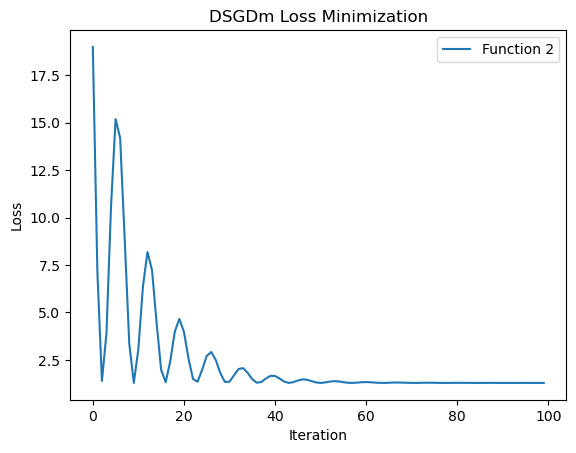

In [5]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 二変数の凸関数の定義
def function_1(x, y):
    return (x - 4) ** 2 + y ** 2

def function_2(x, y):
    return x ** 2 + (y - 5) ** 2

# 勾配計算のために関数をPyTorchのテンソルを用いて定義
def function_1_tensor(params):
    x, y = params[0], params[1]
    return (x - 4) ** 2 + y ** 2

def function_2_tensor(params):
    x, y = params[0], params[1]
    return x ** 2 + (y - 5) ** 2

# シミュレーションパラメータ
num_workers = 4  # ワーカー数
learning_rate = 0.1
num_iterations = 100
momentum = 0.9

# 初期化
params = [torch.randn(2, requires_grad=True) for _ in range(num_workers)]
optimizers = [optim.SGD([param], lr=learning_rate, momentum=momentum) for param in params]

# DSGDmシミュレーション
def dsgdm_minimize(function_tensor, params, optimizers, num_iterations, num_workers, function_name):
    loss_values = []
    for iteration in range(num_iterations):
        # 各ワーカーが独立に勾配を計算
        local_grads = []
        for i in range(num_workers):
            optimizers[i].zero_grad()
            loss = function_tensor(params[i])
            loss.backward()
            local_grads.append(params[i].grad.clone())

        # グローバル平均勾配を計算
        global_grad = sum(local_grads) / num_workers

        # 各ワーカーのパラメータを更新
        for i in range(num_workers):
            params[i].grad = global_grad
            optimizers[i].step()

        # 損失値を記録
        avg_loss = sum(function_tensor(param).item() for param in params) / num_workers
        loss_values.append(avg_loss)

        # 現在の状態を出力
        if iteration % 10 == 0 or iteration == num_iterations - 1:
            print(f"Iteration {iteration}: Params {[param.detach().numpy() for param in params]} ")
    
    # 損失値の可視化
    plt.plot(range(num_iterations), loss_values, label=function_name)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('DSGDm Loss Minimization')
    plt.legend()
    plt.show()

# Function 1 の最小化
dsgdm_minimize(function_1_tensor, params, optimizers, num_iterations, num_workers, 'Function 1')

# Function 2 の最小化
params = [torch.randn(2, requires_grad=True) for _ in range(num_workers)]
optimizers = [optim.SGD([param], lr=learning_rate, momentum=momentum) for param in params]
dsgdm_minimize(function_2_tensor, params, optimizers, num_iterations, num_workers, 'Function 2')


SGD (No Momentum) - Iteration 0: Param [-3.9999998] Loss 25.0
SGD (No Momentum) - Iteration 1: Param [3.1999996] Loss 15.999998092651367
SGD (No Momentum) - Iteration 2: Param [-2.5599995] Loss 10.239996910095215
SGD (No Momentum) - Iteration 3: Param [2.0479994] Loss 6.553597450256348
SGD (No Momentum) - Iteration 4: Param [-1.6383994] Loss 4.194301605224609
SGD (No Momentum) - Iteration 5: Param [1.3107194] Loss 2.684352397918701
SGD (No Momentum) - Iteration 6: Param [-1.0485754] Loss 1.7179852724075317
SGD (No Momentum) - Iteration 7: Param [0.8388603] Loss 1.0995104312896729
SGD (No Momentum) - Iteration 8: Param [-0.67108816] Loss 0.703686535358429
SGD (No Momentum) - Iteration 9: Param [0.5368705] Loss 0.4503593146800995
SGD (No Momentum) - Iteration 10: Param [-0.42949635] Loss 0.28822991251945496
SGD (No Momentum) - Iteration 11: Param [0.34359705] Loss 0.1844671070575714
SGD (No Momentum) - Iteration 12: Param [-0.27487764] Loss 0.1180589348077774
SGD (No Momentum) - Iteratio

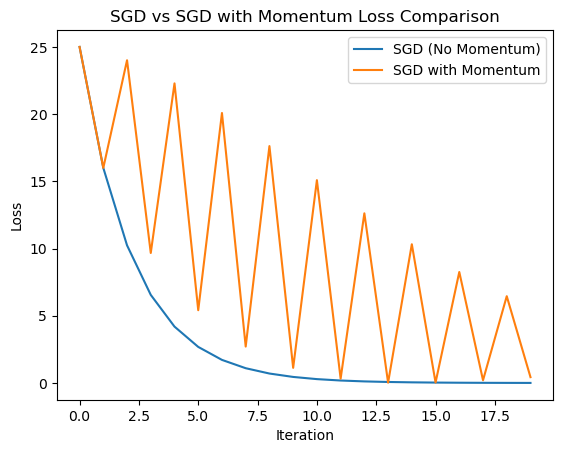

In [6]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 二変数の凸関数の定義
def function(x):
    return x ** 2

# 勾配計算のために関数をPyTorchのテンソルを用いて定義
def function_tensor(param):
    x = param[0]
    return x ** 2

# シミュレーションパラメータ
learning_rate = 0.9
num_iterations = 20
initial_value = 5.0
momentum = 0.9

# モメンタムなしの場合の最適化
def sgd_minimize(function_tensor, param, optimizer, num_iterations, function_name):
    loss_values = []
    for iteration in range(num_iterations):
        optimizer.zero_grad()
        loss = function_tensor(param)
        loss.backward()
        optimizer.step()

        # 損失値を記録
        loss_values.append(loss.item())

        # 現在の状態を出力
        print(f"{function_name} - Iteration {iteration}: Param {param.detach().numpy()} Loss {loss.item()}")
    
    # 損失値の可視化
    plt.plot(range(num_iterations), loss_values, label=function_name)

# モメンタムなしのSGD
param = torch.tensor([initial_value], requires_grad=True)
optimizer = optim.SGD([param], lr=learning_rate)
sgd_minimize(function_tensor, param, optimizer, num_iterations, 'SGD (No Momentum)')

# モメンタムありのSGD
param = torch.tensor([initial_value], requires_grad=True)
optimizer = optim.SGD([param], lr=learning_rate, momentum=momentum)
sgd_minimize(function_tensor, param, optimizer, num_iterations, 'SGD with Momentum')

# 損失値の可視化
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('SGD vs SGD with Momentum Loss Comparison')
plt.legend()
plt.show()


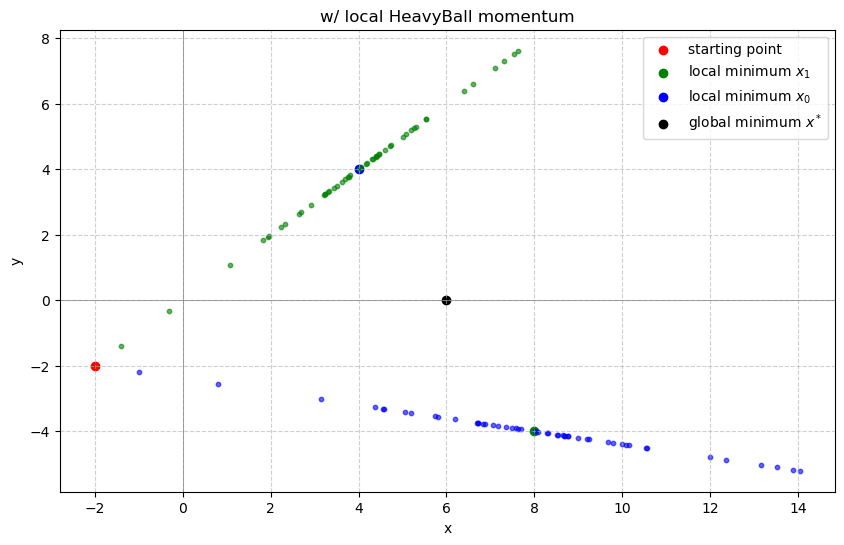

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータ設定
beta = 0.9  # モーメンタム係数
num_steps = 50  # 更新ステップ数

# 各ワーカーの初期位置
worker1_position = np.array([-2.0, -2.0])
worker2_position = np.array([-2.0, -2.0])

# ローカルモーメンタムの初期化
momentum1 = np.array([0.0, 0.0])
momentum2 = np.array([0.0, 0.0])

# 局所最小値と大域最小値の位置
local_min1 = np.array([8.0, -4.0])
local_min2 = np.array([4.0, 4.0])
global_min = np.array([6.0, 0.0])

# 学習率
learning_rate = 0.1

# プロットの準備
plt.figure(figsize=(10, 6))
plt.scatter(*worker1_position, color='red', label='starting point')
plt.scatter(*local_min1, color='green', label='local minimum $x_1$')
plt.scatter(*local_min2, color='blue', label='local minimum $x_0$')
plt.scatter(*global_min, color='black', label='global minimum $x^*$')

# ワーカーごとの色
colors = ['blue', 'green']

# 更新のシミュレーション
for step in range(num_steps):
    # 勾配計算（シンプルな二次関数の勾配を想定）
    grad1 = worker1_position - local_min1
    grad2 = worker2_position - local_min2

    # モーメンタムの更新
    momentum1 = beta * momentum1 + learning_rate * grad1
    momentum2 = beta * momentum2 + learning_rate * grad2

    # 位置の更新
    worker1_position -= momentum1
    worker2_position -= momentum2

    # 現在の位置をプロット
    plt.scatter(*worker1_position, color=colors[0], alpha=0.6, s=10)
    plt.scatter(*worker2_position, color=colors[1], alpha=0.6, s=10)

# 結果のプロット
plt.xlabel('x')
plt.ylabel('y')
plt.title('w/ local HeavyBall momentum')
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


Epoch 1 (No Momentum) - Gradient: -0.9949242312069368, Update: 0.09949242312069369, Loss: 2.969181624901126
Epoch 1 (With Momentum) - Gradient: -0.9949242312069368, Update: 0.09949242312069369, Loss: 2.969181624901126
Epoch 2 (No Momentum) - Gradient: -0.9610901075194278, Update: 0.09610901075194278, Loss: 2.7875839682253014
Epoch 2 (With Momentum) - Gradient: -0.9610901075194278, Update: 0.18565219156056711, Loss: 2.624045666715761
Epoch 3 (No Momentum) - Gradient: -0.9284065718765109, Update: 0.0928406571876511, Loss: 2.618127387907938
Epoch 3 (With Momentum) - Gradient: -0.9284065718765109, Update: 0.3494708104007858, Loss: 2.03795931445094
Epoch 4 (No Momentum) - Gradient: -0.8968344965366031, Update: 0.08968344965366032, Loss: 2.4600001678848495
Epoch 4 (With Momentum) - Gradient: -0.8968344965366031, Update: 0.6608373322275023, Loss: 1.1567358315967142
Epoch 5 (No Momentum) - Gradient: -0.8663360843648189, Update: 0.0866336084364819, Loss: 2.31244486100092
Epoch 5 (With Momentum)

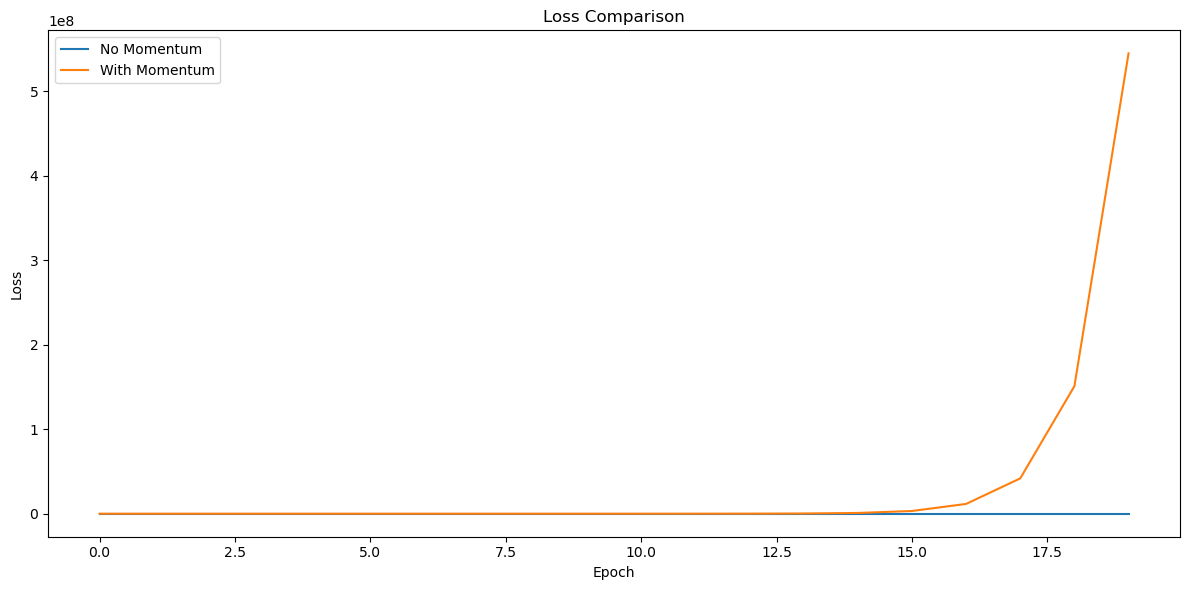

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# データセットの作成
np.random.seed(0)
x_data = np.linspace(-1, 1, 100)
y_data = 3 * x_data + np.random.randn(*x_data.shape) * 0.5  # ノイズ付き直線データ

# モデルの初期化
np.random.seed(0)
w = 0.0
momentum_w = 0.0
learning_rate = 0.1
momentum_rate = 0.9
epochs = 20

# モメンタムなしとありの比較結果を保存するリスト
losses_no_momentum = []
losses_with_momentum = []

# トレーニングループ
for epoch in range(epochs):
    grad = 0
    for x, y in zip(x_data, y_data):
        prediction = w * x
        error = prediction - y
        grad += error * x
    grad /= len(x_data)

    # モメンタムなしの更新
    update = -learning_rate * grad
    w += update

    # 損失計算
    loss = np.mean((w * x_data - y_data) ** 2)
    losses_no_momentum.append(loss)
    print(f"Epoch {epoch + 1} (No Momentum) - Gradient: {grad}, Update: {update}, Loss: {loss}")

    # モメンタムありの更新
    momentum_update = momentum_rate * momentum_w - learning_rate * grad
    momentum_w += momentum_update

    # 損失計算
    loss_momentum = np.mean((momentum_w * x_data - y_data) ** 2)
    losses_with_momentum.append(loss_momentum)
    print(f"Epoch {epoch + 1} (With Momentum) - Gradient: {grad}, Update: {momentum_update}, Loss: {loss_momentum}")

# グラフ描画
plt.figure(figsize=(12, 6))

plt.plot(losses_no_momentum, label='No Momentum')
plt.plot(losses_with_momentum, label='With Momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1 (No Momentum) - Gradient: 0.02512372940942858, Update: -0.002512372940942858, Loss: 2.857932568088144
Epoch 1 (With Momentum) - Gradient: 0.02512372940942858, Update: -0.002512372940942858, Loss: 2.857932568088144
Epoch 2 (No Momentum) - Gradient: 0.02427772627625391, Update: -0.0024277726276253912, Loss: 2.857816671230717
Epoch 2 (With Momentum) - Gradient: 0.02427772627625391, Update: -0.004688908274473963, Loss: 2.8577122994270083
Epoch 3 (No Momentum) - Gradient: 0.023460211003686164, Update: -0.0023460211003686164, Loss: 2.8577084482561093
Epoch 3 (With Momentum) - Gradient: 0.023460211003686164, Update: -0.008827174194243757, Loss: 2.8573378047913724
Epoch 4 (No Momentum) - Gradient: 0.02267022430662307, Update: -0.002267022430662307, Loss: 2.857607391053242
Epoch 4 (With Momentum) - Gradient: 0.02267022430662307, Update: -0.016692632299356826, Loss: 2.8567730630550403
Epoch 5 (No Momentum) - Gradient: 0.021906839202420335, Update: -0.0021906839202420337, Loss: 2.85751302

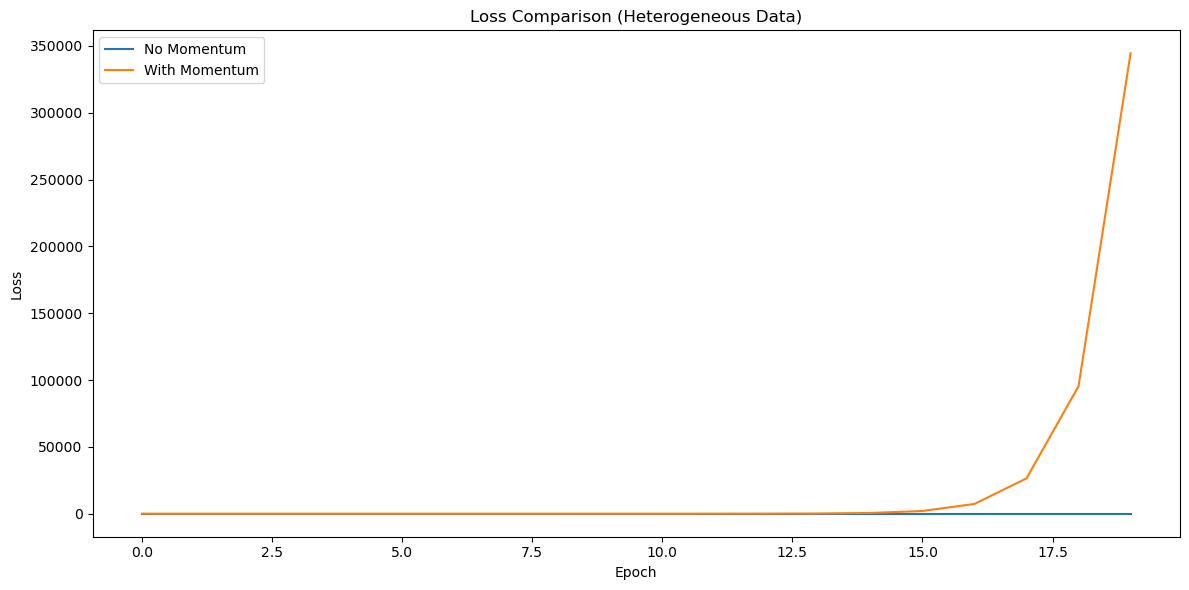

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# データセットの作成 (異質性を追加)
np.random.seed(0)
x_data_1 = np.linspace(-1, 0, 50)
y_data_1 = 3 * x_data_1 + np.random.randn(*x_data_1.shape) * 0.5  # ノイズ付き直線データ
x_data_2 = np.linspace(0, 1, 50)
y_data_2 = -3 * x_data_2 + np.random.randn(*x_data_2.shape) * 0.5  # 異なる勾配のデータ

x_data = np.concatenate([x_data_1, x_data_2])
y_data = np.concatenate([y_data_1, y_data_2])

# モデルの初期化
np.random.seed(0)
w = 0.0
momentum_w = 0.0
learning_rate = 0.1
momentum_rate = 0.9
epochs = 20

# モメンタムなしとありの比較結果を保存するリスト
losses_no_momentum = []
losses_with_momentum = []

# トレーニングループ
for epoch in range(epochs):
    grad = 0
    for x, y in zip(x_data, y_data):
        prediction = w * x
        error = prediction - y
        grad += error * x
    grad /= len(x_data)

    # モメンタムなしの更新
    update = -learning_rate * grad
    w += update

    # 損失計算
    loss = np.mean((w * x_data - y_data) ** 2)
    losses_no_momentum.append(loss)
    print(f"Epoch {epoch + 1} (No Momentum) - Gradient: {grad}, Update: {update}, Loss: {loss}")

    # モメンタムありの更新
    momentum_update = momentum_rate * momentum_w - learning_rate * grad
    momentum_w += momentum_update

    # 損失計算
    loss_momentum = np.mean((momentum_w * x_data - y_data) ** 2)
    losses_with_momentum.append(loss_momentum)
    print(f"Epoch {epoch + 1} (With Momentum) - Gradient: {grad}, Update: {momentum_update}, Loss: {loss_momentum}")

# グラフ描画
plt.figure(figsize=(12, 6))

plt.plot(losses_no_momentum, label='No Momentum')
plt.plot(losses_with_momentum, label='With Momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison (Heterogeneous Data)')
plt.legend()

plt.tight_layout()
plt.show()
